# XGBoost Most Important Features

In [42]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb

import matplotlib.pyplot as plt 
import seaborn as sns
import ppscore as pps

## Read in and Split Data

In [43]:
# read in data
data = pd.read_csv('../data/unemployment_data.csv')
data.head()

,initclaims_rate_regular,FIPS,State,County,Deaths,Years of Potential Life Lost Rate,% Fair or Poor Health,Average Number of Physically Unhealthy Days,Average Number of Mentally Unhealthy Days,% Low Birthweight,...,% Below Poverty,Median Household Income,% No College Degree,Unemployment Rate,% Not in Labor Force,% Jobs in Leisure and Hospitality,% Part-time,% Self-Employed,Presence of Water Violation (dummy Y/N),Other Primary Care Provider Ratio (:1)
0,26.0512,1001,Alabama,Autauga,791,8128.59119,20.882987,4.743889,4.654031,8.619529,...,12.1,58233,16.107796,2.7,40.454576,14.216260,39.604710,7.283256,0,2527
1,30.8648,1003,Alabama,Baldwin,2967,7354.12253,17.509134,4.224519,4.304056,8.345003,...,10.1,59871,21.044656,2.7,43.511495,20.823355,40.364194,12.669969,0,1787
2,24.5891,1005,Alabama,Barbour,472,10253.57340,29.591802,5.430279,5.185594,11.474559,...,27.1,35972,7.609664,3.8,58.630549,9.248695,54.696722,9.675502,0,1914
3,35.7501,1007,Alabama,Bibb,471,11977.53948,19.439724,4.591482,4.551699,10.308710,...,20.3,47918,6.451014,3.1,53.033744,4.345937,52.112959,7.547395,0,896
4,15.1614,1009,Alabama,Blount,1085,11335.07113,21.745293,4.860808,4.891455,7.604563,...,16.3,52902,8.625066,2.7,44.821051,10.342057,47.550659,7.815851,0,4449


In [44]:
X = data.drop(["FIPS", "initclaims_rate_regular", "State", "County"], axis=1)
y = pd.DataFrame(data["initclaims_rate_regular"])

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
len(X.columns)

98

## Dummy Baseline

In [47]:
y_train_mean = y_train.mean()
y_train_mean

initclaims_rate_regular    35.337946
dtype: float64

In [48]:
(((y_test - y_train_mean)**2).sum())**(.5)

initclaims_rate_regular    337.99254
dtype: float64

## XGBoost and Feature Importance

In [49]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [50]:
"""
Hyperparameter Tuning from 
https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
"""

params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
    'eval_metric':"rmse"
}

In [51]:
num_boost_round = 999

In [52]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-rmse:29.04443
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:22.87230
[2]	Test-rmse:18.35347
[3]	Test-rmse:16.51931
[4]	Test-rmse:15.00392
[5]	Test-rmse:14.26096
[6]	Test-rmse:13.93238
[7]	Test-rmse:13.86951
[8]	Test-rmse:13.82389
[9]	Test-rmse:13.79095
[10]	Test-rmse:13.74010
[11]	Test-rmse:13.75093
[12]	Test-rmse:13.86983
[13]	Test-rmse:13.88244
[14]	Test-rmse:13.82724
[15]	Test-rmse:13.76797
[16]	Test-rmse:13.82593
[17]	Test-rmse:13.87027
[18]	Test-rmse:13.83642
[19]	Test-rmse:13.85011
[20]	Test-rmse:13.81506
Stopping. Best iteration:
[10]	Test-rmse:13.74010



In [53]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'rmse'},
    early_stopping_rounds=10
)
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,31.804437,0.656096,32.876118,3.167947
1,24.327171,0.605364,27.063403,3.413427
2,18.996865,0.465853,23.394540,3.433107
3,15.097599,0.360949,21.292663,3.525922
4,12.272585,0.384253,20.351045,3.437839
...,...,...,...,...
62,0.227140,0.023814,19.370849,2.986484
63,0.217412,0.024065,19.370013,2.987706
64,0.201427,0.019521,19.368734,2.987081
65,0.190315,0.021384,19.368614,2.987278


In [54]:
cv_results['test-rmse-mean'].min()

19.367247600000002

### Tune max_depth and min_child_weight

In [55]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]

In [56]:
# Define initial best params and rmse
min_rmse = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best rmse
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\trmse {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, rmse: {}".format(best_params[0], best_params[1], min_rmse))

CV with max_depth=9, min_child_weight=5
	rmse 18.2472112 for 11 rounds
CV with max_depth=9, min_child_weight=6
	rmse 18.7568408 for 11 rounds
CV with max_depth=9, min_child_weight=7
	rmse 18.868578 for 21 rounds
CV with max_depth=10, min_child_weight=5
	rmse 18.426302399999997 for 16 rounds
CV with max_depth=10, min_child_weight=6
	rmse 18.819822600000002 for 13 rounds
CV with max_depth=10, min_child_weight=7
	rmse 19.0584232 for 13 rounds
CV with max_depth=11, min_child_weight=5
	rmse 18.557368000000004 for 12 rounds
CV with max_depth=11, min_child_weight=6
	rmse 19.029536 for 12 rounds
CV with max_depth=11, min_child_weight=7
	rmse 19.299321400000004 for 16 rounds
Best params: 9, 5, rmse: 18.2472112


In [57]:
params['max_depth'] = 9
params['min_child_weight'] = 5

### Tune subsample and colsample

In [58]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [59]:
min_rmse = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\trmse {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (subsample,colsample)
print("Best params: {}, {}, rmse: {}".format(best_params[0], best_params[1], min_rmse))

CV with subsample=1.0, colsample=1.0
	rmse 18.2472112 for 11 rounds
CV with subsample=1.0, colsample=0.9
	rmse 18.5399906 for 13 rounds
CV with subsample=1.0, colsample=0.8
	rmse 17.71241 for 25 rounds
CV with subsample=1.0, colsample=0.7
	rmse 17.8294726 for 10 rounds
CV with subsample=0.9, colsample=1.0
	rmse 18.1836916 for 17 rounds
CV with subsample=0.9, colsample=0.9
	rmse 17.997306 for 12 rounds
CV with subsample=0.9, colsample=0.8
	rmse 18.3144626 for 11 rounds
CV with subsample=0.9, colsample=0.7
	rmse 18.3794606 for 13 rounds
CV with subsample=0.8, colsample=1.0
	rmse 18.475067199999998 for 18 rounds
CV with subsample=0.8, colsample=0.9
	rmse 18.811882199999996 for 10 rounds
CV with subsample=0.8, colsample=0.8
	rmse 18.5146136 for 11 rounds
CV with subsample=0.8, colsample=0.7
	rmse 18.5528504 for 18 rounds
CV with subsample=0.7, colsample=1.0
	rmse 18.6839848 for 11 rounds
CV with subsample=0.7, colsample=0.9
	rmse 18.392864600000003 for 10 rounds
CV with subsample=0.7, cols

In [60]:
params['subsample'] = 1.0
params['colsample_bytree'] = 0.8

### Tune eta

In [61]:
min_rmse = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    cv_results = xgb.cv(params, dtrain, num_boost_round=num_boost_round, seed=42, nfold=5, metrics=['rmse'], early_stopping_rounds=10)
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\trmse {} for {} rounds\n".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = eta
print("Best params: {}, rmse: {}".format(best_params, min_rmse))

CV with eta=0.3
	rmse 17.71241 for 25 rounds

CV with eta=0.2
	rmse 17.8797264 for 29 rounds

CV with eta=0.1
	rmse 17.4569894 for 39 rounds

CV with eta=0.05
	rmse 17.599973800000004 for 84 rounds

CV with eta=0.01
	rmse 17.2911808 for 395 rounds

CV with eta=0.005
	rmse 17.2643998 for 853 rounds

Best params: 0.005, rmse: 17.2643998


In [62]:
params['eta'] = .005

In [63]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-rmse:38.45264
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:38.28841
[2]	Test-rmse:38.12163
[3]	Test-rmse:37.95835
[4]	Test-rmse:37.79233
[5]	Test-rmse:37.62979
[6]	Test-rmse:37.46976
[7]	Test-rmse:37.30859
[8]	Test-rmse:37.13986
[9]	Test-rmse:36.97980
[10]	Test-rmse:36.81826
[11]	Test-rmse:36.65801
[12]	Test-rmse:36.50493
[13]	Test-rmse:36.34880
[14]	Test-rmse:36.19237
[15]	Test-rmse:36.03676
[16]	Test-rmse:35.88367
[17]	Test-rmse:35.73025
[18]	Test-rmse:35.57556
[19]	Test-rmse:35.42565
[20]	Test-rmse:35.27469
[21]	Test-rmse:35.13011
[22]	Test-rmse:34.98665
[23]	Test-rmse:34.83632
[24]	Test-rmse:34.69774
[25]	Test-rmse:34.55470
[26]	Test-rmse:34.40937
[27]	Test-rmse:34.26475
[28]	Test-rmse:34.12669
[29]	Test-rmse:33.98291
[30]	Test-rmse:33.84196
[31]	Test-rmse:33.70427
[32]	Test-rmse:33.56272
[33]	Test-rmse:33.41727
[34]	Test-rmse:33.27909
[35]	Test-rmse:33.14422
[36]	Test-rmse:33.00603
[37]	Test-rmse:32.87200
[38]	Test-rmse:32.73915
[39]	Test-rmse:32

[330]	Test-rmse:13.98940
[331]	Test-rmse:13.97100
[332]	Test-rmse:13.95473
[333]	Test-rmse:13.93604
[334]	Test-rmse:13.91907
[335]	Test-rmse:13.90106
[336]	Test-rmse:13.88255
[337]	Test-rmse:13.86598
[338]	Test-rmse:13.84483
[339]	Test-rmse:13.82596
[340]	Test-rmse:13.80989
[341]	Test-rmse:13.79494
[342]	Test-rmse:13.77803
[343]	Test-rmse:13.76493
[344]	Test-rmse:13.74861
[345]	Test-rmse:13.73229
[346]	Test-rmse:13.72069
[347]	Test-rmse:13.70223
[348]	Test-rmse:13.68655
[349]	Test-rmse:13.66825
[350]	Test-rmse:13.65392
[351]	Test-rmse:13.63621
[352]	Test-rmse:13.61965
[353]	Test-rmse:13.60402
[354]	Test-rmse:13.58347
[355]	Test-rmse:13.56860
[356]	Test-rmse:13.55394
[357]	Test-rmse:13.53670
[358]	Test-rmse:13.52584
[359]	Test-rmse:13.51275
[360]	Test-rmse:13.49968
[361]	Test-rmse:13.48533
[362]	Test-rmse:13.47248
[363]	Test-rmse:13.45390
[364]	Test-rmse:13.44105
[365]	Test-rmse:13.42986
[366]	Test-rmse:13.41845
[367]	Test-rmse:13.40278
[368]	Test-rmse:13.39106
[369]	Test-rmse:13.37783


In [64]:
print("Best RMSE: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))

Best RMSE: 12.37 in 585 rounds


### Get and save best model

In [65]:
num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")]
)

[0]	Test-rmse:38.45264
[1]	Test-rmse:38.28841
[2]	Test-rmse:38.12163
[3]	Test-rmse:37.95835
[4]	Test-rmse:37.79233
[5]	Test-rmse:37.62979
[6]	Test-rmse:37.46976
[7]	Test-rmse:37.30859
[8]	Test-rmse:37.13985
[9]	Test-rmse:36.97980
[10]	Test-rmse:36.81826
[11]	Test-rmse:36.65801
[12]	Test-rmse:36.50493
[13]	Test-rmse:36.34879
[14]	Test-rmse:36.19237
[15]	Test-rmse:36.03676
[16]	Test-rmse:35.88367
[17]	Test-rmse:35.73025
[18]	Test-rmse:35.57556
[19]	Test-rmse:35.42565
[20]	Test-rmse:35.27469
[21]	Test-rmse:35.13011
[22]	Test-rmse:34.98665
[23]	Test-rmse:34.83632
[24]	Test-rmse:34.69774
[25]	Test-rmse:34.55470
[26]	Test-rmse:34.40937
[27]	Test-rmse:34.26475
[28]	Test-rmse:34.12669
[29]	Test-rmse:33.98291
[30]	Test-rmse:33.84196
[31]	Test-rmse:33.70427
[32]	Test-rmse:33.56272
[33]	Test-rmse:33.41727
[34]	Test-rmse:33.27909
[35]	Test-rmse:33.14422
[36]	Test-rmse:33.00603
[37]	Test-rmse:32.87200
[38]	Test-rmse:32.73915
[39]	Test-rmse:32.60903
[40]	Test-rmse:32.47392
[41]	Test-rmse:32.34297
[4

[333]	Test-rmse:13.93604
[334]	Test-rmse:13.91907
[335]	Test-rmse:13.90106
[336]	Test-rmse:13.88255
[337]	Test-rmse:13.86598
[338]	Test-rmse:13.84483
[339]	Test-rmse:13.82596
[340]	Test-rmse:13.80989
[341]	Test-rmse:13.79494
[342]	Test-rmse:13.77803
[343]	Test-rmse:13.76493
[344]	Test-rmse:13.74861
[345]	Test-rmse:13.73229
[346]	Test-rmse:13.72069
[347]	Test-rmse:13.70224
[348]	Test-rmse:13.68655
[349]	Test-rmse:13.66825
[350]	Test-rmse:13.65392
[351]	Test-rmse:13.63621
[352]	Test-rmse:13.61965
[353]	Test-rmse:13.60402
[354]	Test-rmse:13.58347
[355]	Test-rmse:13.56860
[356]	Test-rmse:13.55394
[357]	Test-rmse:13.53670
[358]	Test-rmse:13.52584
[359]	Test-rmse:13.51275
[360]	Test-rmse:13.49968
[361]	Test-rmse:13.48533
[362]	Test-rmse:13.47248
[363]	Test-rmse:13.45390
[364]	Test-rmse:13.44105
[365]	Test-rmse:13.42986
[366]	Test-rmse:13.41845
[367]	Test-rmse:13.40278
[368]	Test-rmse:13.39106
[369]	Test-rmse:13.37783
[370]	Test-rmse:13.36769
[371]	Test-rmse:13.35736
[372]	Test-rmse:13.34631


In [66]:
best_model.save_model("my_model.model")

In [67]:
(mean_squared_error(best_model.predict(dtest), y_test))**.5

12.369960193608192

### Feature Importance

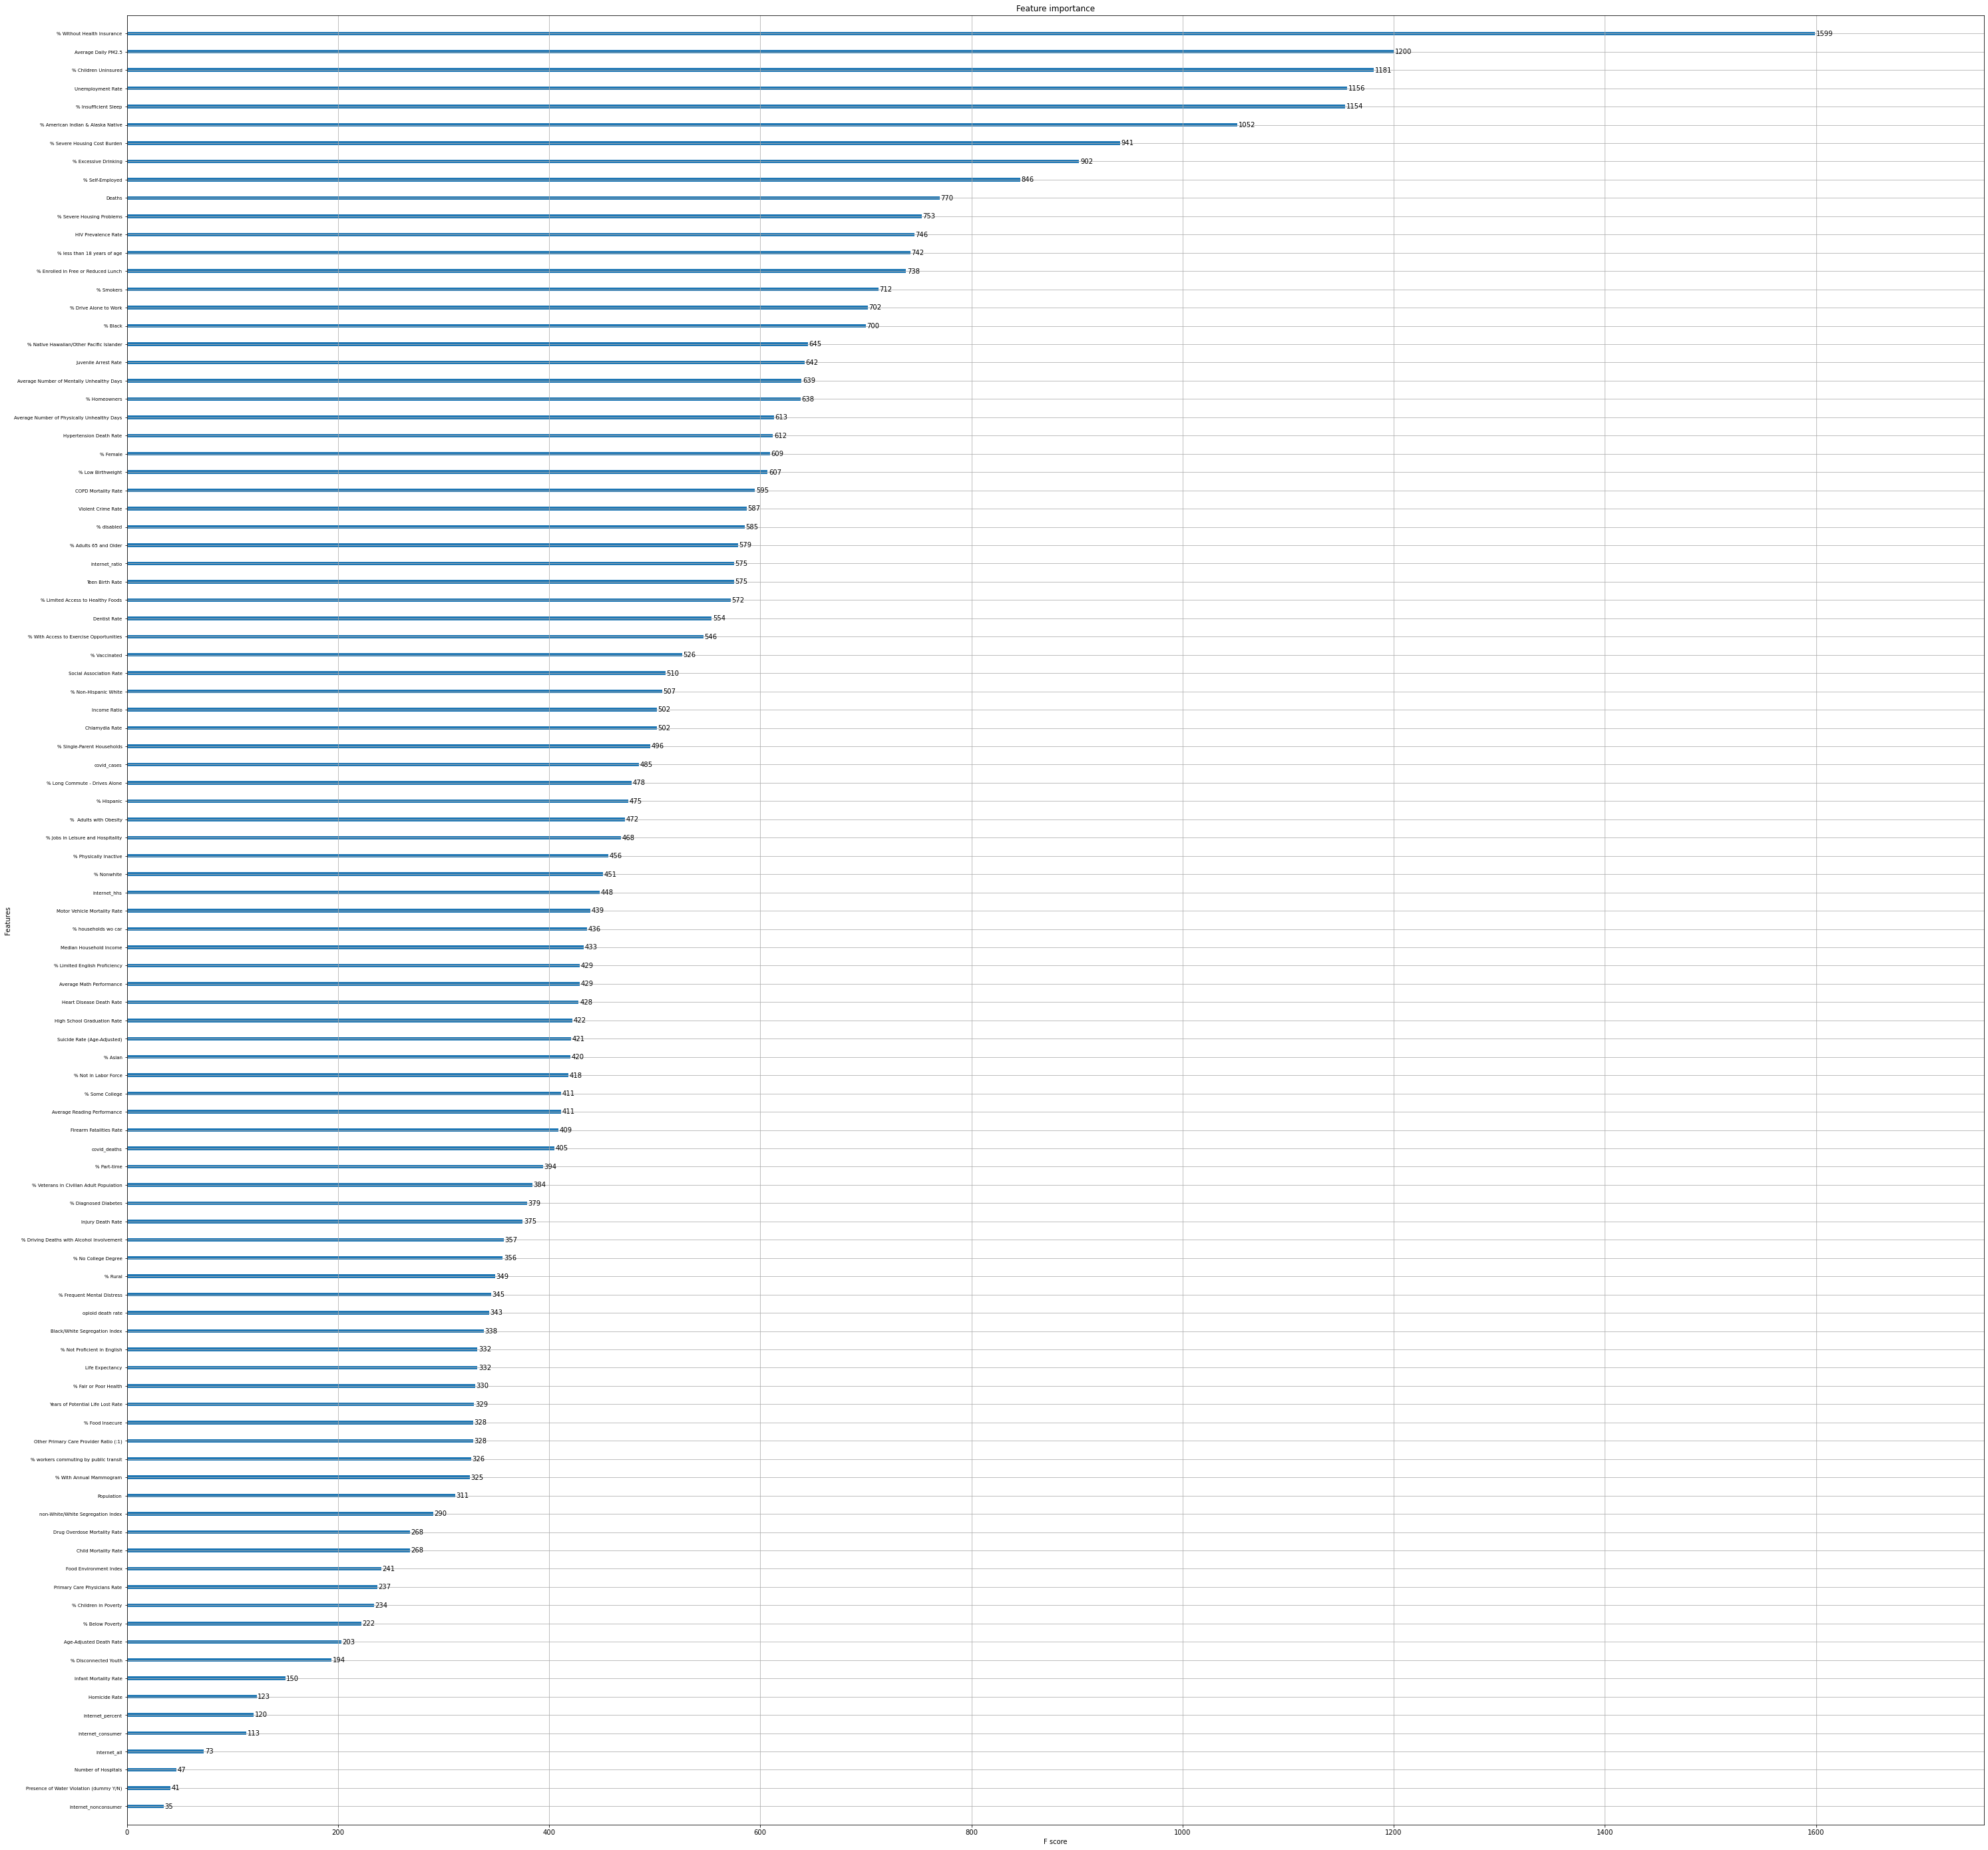

In [69]:
xgb.plot_importance(best_model)
plt.rcParams['figure.figsize'] = [50, 50]
plt.yticks(size = 7)
plt.show()

### The following are the 9 most important features (F-score > 350):
1. % Without Health Insurance
2. Average Daily PM2.5
3. % Children Uninsured
4. Unemployment Rate
5. % Insufficient Sleep
6. % American Indian & Alaska Native
7. % Severe Housing Cost Burden
8. % Excessive Drinking
9. % Self-Employed

### Correlation

In [70]:
X_x = X.filter(['% Without Health Insurance', 'Average Daily PM2.5',
                '% Children Uninsured', 'Unemployment Rate',
                '% Insufficient Sleep', '% American Indian & Alaska Native',
                '% Severe Housing Cost Burden', '% Excessive Drinking', 
                '% Self-Employed'])

In [71]:
Correlation_Matrix=X_x.corr().abs()
Correlation_Matrix

,% Without Health Insurance,Average Daily PM2.5,% Children Uninsured,Unemployment Rate,% Insufficient Sleep,% American Indian & Alaska Native,% Severe Housing Cost Burden,% Excessive Drinking,% Self-Employed
% Without Health Insurance,1.000000,0.080003,0.703811,0.050551,0.146990,0.126343,0.100460,0.532850,0.157360
Average Daily PM2.5,0.080003,1.000000,0.279847,0.138582,0.497415,0.228794,0.024813,0.172273,0.557292
% Children Uninsured,0.703811,0.279847,1.000000,0.154340,0.093219,0.124038,0.134420,0.201023,0.415795
Unemployment Rate,0.050551,0.138582,0.154340,1.000000,0.371358,0.191300,0.223190,0.232310,0.200050
% Insufficient Sleep,0.146990,0.497415,0.093219,0.371358,1.000000,0.051728,0.280511,0.484597,0.542423
% American Indian & Alaska Native,0.126343,0.228794,0.124038,0.191300,0.051728,1.000000,0.021491,0.013423,0.037824
% Severe Housing Cost Burden,0.100460,0.024813,0.134420,0.223190,0.280511,0.021491,1.000000,0.150431,0.111967
% Excessive Drinking,0.532850,0.172273,0.201023,0.232310,0.484597,0.013423,0.150431,1.000000,0.052126
% Self-Employed,0.157360,0.557292,0.415795,0.200050,0.542423,0.037824,0.111967,0.052126,1.000000


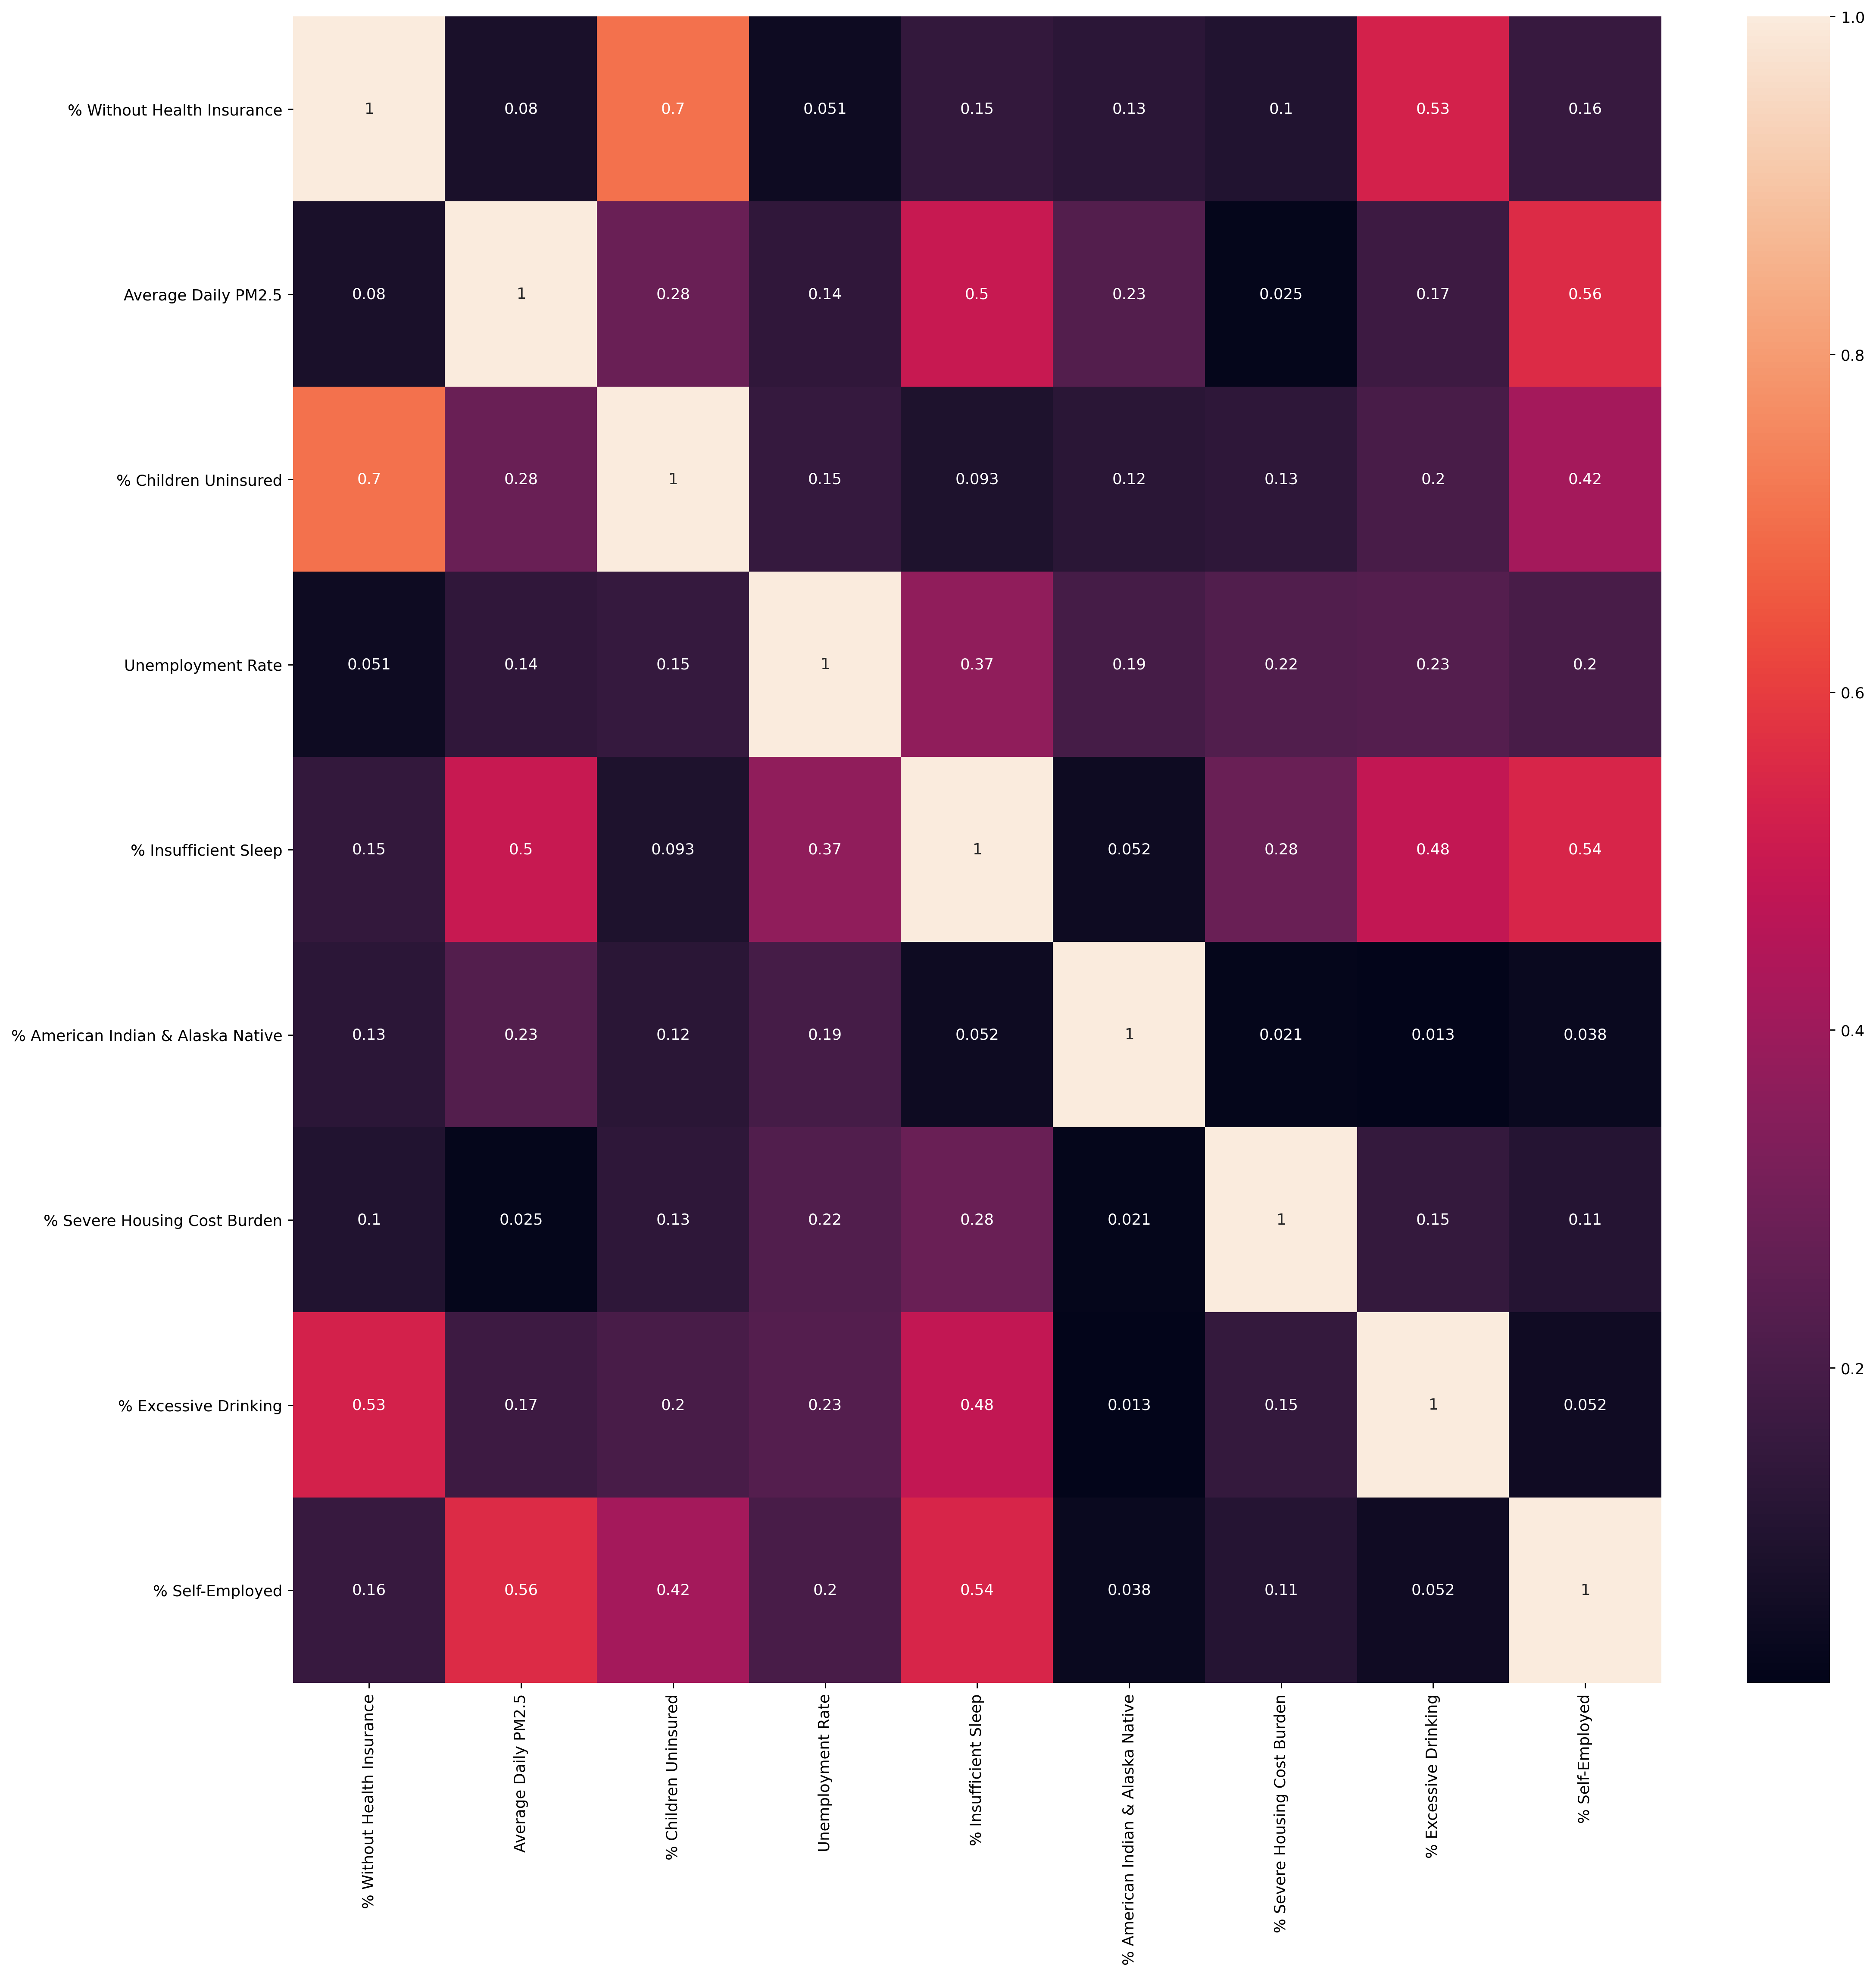

In [72]:
plt.figure(figsize=[20,20],dpi=256)
sns.heatmap(Correlation_Matrix, annot=True)

plt.show()

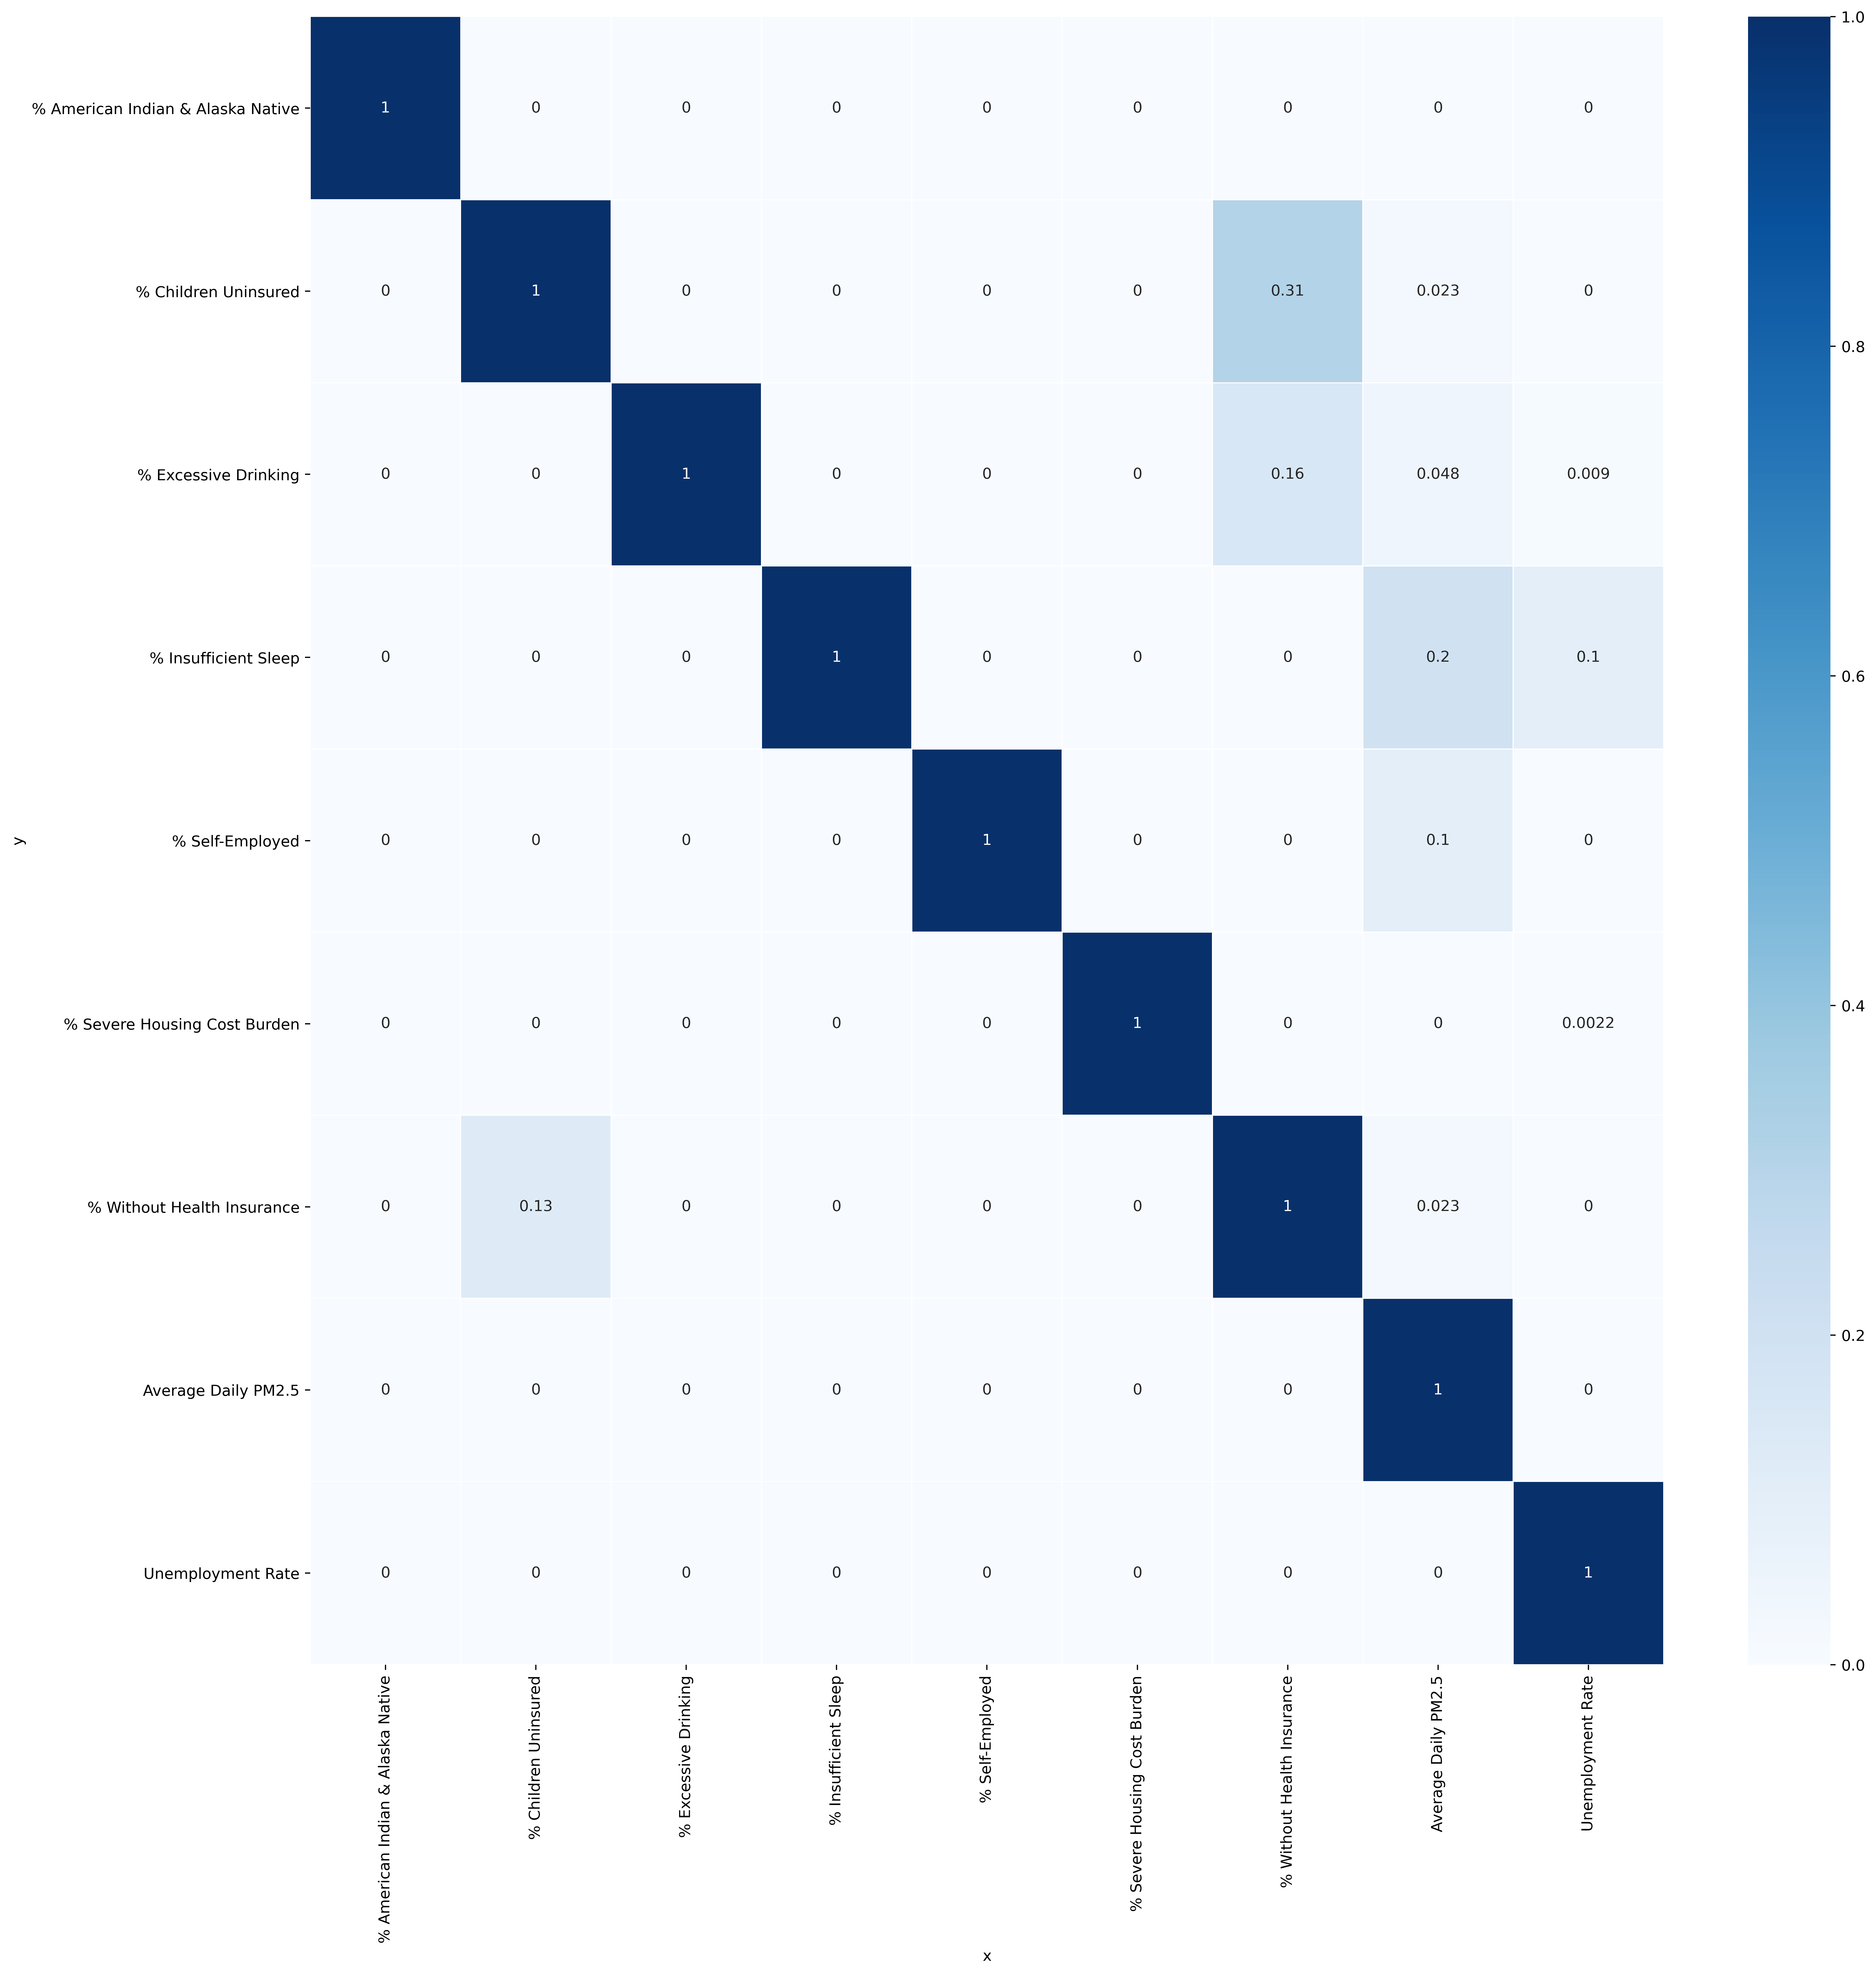

In [73]:
plt.figure(figsize=[20,20],dpi=400)
a = pps.matrix(X_x).pivot(columns='x', index='y', values='ppscore')
sns.heatmap(a, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)
plt.show()